# Interactive Machine Learning - Exercise 04


## 0. Import the libraries
As always we are providing a list useful packages in the import section below.
Keep in mind that you can import additional libraries at any time and that you do not need to use all the imports if you know another solution for a given task.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
import ipywidgets as widgets
import os
import numpy as np
import glob
import random
import operator
import matplotlib.pyplot as plt
from IPython.display import Image, clear_output
from ipywidgets import interact_manual, GridspecLayout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from shutil import copyfile
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.Evaluation
In this exercise you are supposed to write a method that evaluate one of your previously trained classifiers and
allows you to gain initial insights into the inner workings of your model.
You can choose freely whether you would like to use a model from exercise 02 or 03 or train a new model for all pokemon by yourself.
After loading your model and the respective weights, create a prediction for each image in the validation-set of the respective dataset your model has been trained on.
Afterwards, generate an output for each image containing the following information:

* Image id
* Image filename
* Ground truth label
* Prediction
* Prediction probabilities sorted in ascending order with class names

The output could have following form:

* 1) b1.jpg Truth: 0 | Prediction 0 - [Bulbasaur:0.93, Vaporon: 0.04, Squirtle: 0.03, Pikachu: 0.00, Jolteon: 0.00, Evee: 0.00, Flareon: 0.00, Charmander: 0.00]
* 2) ...
* 3) ...

Finally, examine all wrongly classified images and compare them visually to images of the predicted class.
What do you notice? Are there any visual similarities that might lead your model to make the wrong prediction?

NOTE: If you trained your model well, you might end up with 100% recognition rate on the validation set.
In this case, for the sake of the exercise, follow this protocol:

1) Accept gratulations for your superb model
2) Choose an earlier checkpoint from this training
3) Repeat till your model does not achieve 100% prediction accuracy

### 1. Code here

#### X-values

In [7]:
#PATH = '/content/gdrive/MyDrive/ColabData/pokemons/imgs/*'
PATH = '../imgs/*'
IMAGE_SIZE = (224, 224)

X = [image.load_img(file, color_mode='rgb', target_size=IMAGE_SIZE, interpolation='nearest') for file in glob.glob(PATH)]
X_array = [image.img_to_array(x_, data_format=None, dtype=None) for x_ in X]
X_prep =  [preprocess_input(x_) for x_ in X_array]

print("Number of proprocessed images: {}.The shape of one of the new preprocessed pictures in X_preprocessed: {} ".format(len(X_prep), X_prep[0].shape))

Number of proprocessed images: 347.The shape of one of the new preprocessed pictures in X_preprocessed: (224, 224, 3) 


#### Y-values

In [9]:
pokemons = ['bulbasaur', 'charmander', 'eevee', 'flareon', 'jolteon', 'pikachu', 'squirtle', 'vaporeon']

# COLAB : path is equal to /content/gdrive/MyDrive/ColabData/pokemons/imgs/*
# LOCAL: path is equal to imgs/*
y = [pokemons.index(x.split('/')[2].split('_')[0].lower()) for x in glob.glob(PATH)]
y_encoded = to_categorical(y, 8)
print("The shape of encoded labels: {}, first three of them: \n{}".format(y_encoded.shape, y_encoded[:3]))

The shape of encoded labels: (347, 8), first three of them: 
[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


#### Test/val set

In [10]:
X_prep_ndarray = np.array(X_prep, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_prep_ndarray, y_encoded, train_size=0.9, random_state=42)
X_train.shape, y_train.shape

((312, 224, 224, 3), (312, 8))

#### Defining the network and loading weights of the model from previous exercise

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_vgg = VGG16(weights="imagenet", include_top = False, input_shape=(224, 224, 3))
base_vgg.trainable = True
for layer in base_vgg.layers[0:16]:
    layer.trainable =  False

print('>>> base_vgg summary: ')
base_vgg.summary()

input_ = Input(shape=(224, 224, 3))
concat_ = base_vgg(input_, training=False)
maxpool_ = MaxPooling2D()(concat_)
flatten_ = Flatten()(maxpool_)
dense_1 = Dense(1024, activation='relu')(flatten_)
dense_2 = Dense(1024, activation='relu')(dense_1)
output_ = Dense(8, activation='softmax')(dense_2)
model_vgg = Model(input_, output_)

model_vgg._name = 'Model-XAI'
#model_vgg.load_weights('/content/gdrive/MyDrive/ColabData/model_vgg-pokemons_on_imgs_weights.hdf5')
model_vgg.load_weights('model_vgg-pokemons_on_imgs_weights.hdf5')

print('>>> model_vgg summary : ')
model_vgg.summary()

>>> base_vgg summary: 
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56

In [ ]:
# Checkpoint to save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="best_weights-XAI.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

model_vgg.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics='acc')

history = model_vgg.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, callbacks = [checkpoint_cb])

Creating a prediction and generating an output for each image containing the following information:
*   Image id
*   Image filename
*   Ground truth label
*   Prediction
*   Prediction probabilities sorted in ascending order with class names 

The output could have following form:

1) b1.jpg Truth: 0 | Prediction 0 - [Bulbasaur:0.93, Vaporon: 0.04, Squirtle: 0.03, Pikachu: 0.00, Jolteon: 0.00, Evee: 0.00, Flareon: 0.00, Charmander: 0.00]


##### Building a list of path **A** to the images I trained my model on and then extracting names of these images **A_names**

In [ ]:
A = [open(a_, 'rb') for a_ in glob.glob(PATH)]
print('Number of paths to images : {}. Example of the path : {}'.format(len(A), A[0]))

A_names = [a_.name.split('/')[1] for a_ in A]
print('Number of names of images : {}. Example of the image name : {}'.format(len(A_names), A_names[0]))

##### Splitting the list of images names exactly as train/val variables for comparison later on

In [ ]:
A_train, A_test = train_test_split(A_names, train_size=0.9, random_state=42)

print('Number of validation images passed to model: ', len(X_test))
print('Number of validation names must be equal to X_test: ', len(A_test))

#### Predicting on validation set, rounding up predictions and converting numpray ndarray to list

In [ ]:
y_proba = model_vgg.predict(X_test)
y_proba_round = y_proba.round().tolist()

##### Functions needed for output of part 1

In [5]:
class_names = ["BULBASAUR", "CHARMANDER", "EEVEE", "FLAREON", "JOLTEON", "PIKACHU", "SQUIRTLE", "VAPOREON"]

def find_truth(image):
    """
    Function that finds groundtruth image label

    Parameters:
    ----------
    image:   Receives images name along with it's number and extention.
             Example: JOLTEON_19.jpg

    Returns:
    -------
    groundtruth:  True label of the image.
                  Example: JOLTEON
    """
    image = image.split('_')[0]
    groundtruth = class_names.index(image)
    return groundtruth


def make_dictionary(predictions):
    """ 
    Function that takes predictions and binds them with respective label from class_name list

    Returns:
    -------
    dict_sorted:  Sorted in descending order by value dictionary of label: prediction values
    """
    dict_ = {}
    for i in range(len(predictions)):
        dict_[class_names[i]] = predictions[i]

    dict_sorted = dict(
        sorted(dict_.items(), key=operator.itemgetter(1), reverse=True))
    return dict_sorted

In [6]:
for i in range(35):
    groundtruth = find_truth(A_test[i])
    # max value in predictions
    max_pred = y_proba_round[i].index(max(y_proba_round[i]))
    # dictionary of label : prediction vales
    dict_ = make_dictionary(y_proba_round[i])
    print('{}) {} Truth: {} | Prediction : {} - {}'.format(
        i, A_test[i], groundtruth, max_pred, dict_))

NameError: name 'A_test' is not defined

## QUESTION: Finally, examine all wrongly classified images and compare them visually to images of the predicted class. What do you notice? Are there any visual similarities that might lead your model to make the wrong prediction?

## ANSWER: My model yields no indiferences and every image has 100% probability prediction


### 2. Filtering
In this exercise you will build your own user interface to explore the outputs of specific layers of your network.
The goal is to let a user interactively load an image and then visualize the output of a chosen convolutional layer from the trained networrk for this image.
This UI could look like this, but  feel free to change elements as you like:

* A textfield to specify the path of the input image
* A button to confirm the image
* A dropdown that lets the user choose the convolutional layer
* A plot of the input image
* A slider to choose which feature map (channel) from the output of the convolutional layer should be displayed
* A plot of this feature map

The final UI could look like this
![](https://hcm-lab.de/cloud/index.php/s/aa74Cf5EF7rjxk9/preview)

# 2 Code here

#### Finding convolutional layers and number of filters needed for this task

In [14]:
conv_layers = []
conv_layers_filters = {}

for layer in base_vgg.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    conv_layers.append(layer.name)
    conv_layers_filters[layer.name] = filters.shape[3]

conv_layers_filters

{'block1_conv1': 64,
 'block1_conv2': 64,
 'block2_conv1': 128,
 'block2_conv2': 128,
 'block3_conv1': 256,
 'block3_conv2': 256,
 'block3_conv3': 256,
 'block4_conv1': 512,
 'block4_conv2': 512,
 'block4_conv3': 512,
 'block5_conv1': 512,
 'block5_conv2': 512,
 'block5_conv3': 512}

### Methods to create widgets

In [15]:
textfield = widgets.Text(value='PIKACHU_40.png', placeholder='Your image', description='Image path:')

def create_textfield():
    return textfield


def create_interact_button():
    button = widgets.Button(description='Run Interact', button_style='success')
    button.on_click(on_interact)
    return button


def create_image_original(path_to_image=''):
    if path_to_image == '':
        return widgets.Textarea(value='You need to select an image first')
    else:
        file = open(path_to_image, "rb")
        image = file.read()
        return widgets.Image(value=image)


dropdown = widgets.Dropdown(options=conv_layers, description='Conv Layer:',continuous_update=True)

def create_conv_dropdown():
    return dropdown


filter_ = widgets.IntSlider(value = 10, min = 0, max = 64, step = 1,description = 'Output filter:',
                           continuous_update = False, orientation = 'horizontal', readout = True, readout_format = 'd')

def create_conv_button():
    button = widgets.Button(description='Select Conv Layer', button_style='info')
    button.on_click(on_conv_layer)
    return button

def create_filter(filter_number):
    filter_.max = filter_number
    return filter_

def create_filter_button():
    button = widgets.Button(description='Select Filter', button_style='warning')
    button.on_click(on_filter)
    return button

### This next cell performs image preprocessing, convolution layer matchins etc

In [16]:
# Extracting the outputs of the base_model where all convolutions are
layer_outputs = [layer.output for layer in base_vgg.layers] 

# Creating a model that will return these outputs, given the model input
activation_model = Model(inputs=base_vgg.input, outputs=layer_outputs) 

def image_preprocess(img_path):
    """
    This function takes an image, preprocesses it for model and eturns a list of five Numpy arrays: one array per layer activation
    """
    #IMAGE_SIZE is equal to (224,224)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_tensor = image.img_to_array(img)

    img_prep = preprocess_input(img_tensor) 
    img_array = np.array(img_prep, dtype=np.float32)
    img_ready = np.expand_dims(img_array, axis=0)

    activations = activation_model.predict(img_ready) 
    return(activations)

### Collable methods by widgets

In [17]:
full_path = ''
conv_block = ''
filter_number = 0

def on_interact(button):
    """
    This function displays chosen by path image
    """
    #PATH_TO_IMAGES = '/content/gdrive/MyDrive/ColabData/pokemons/imgs/'
    PATH_TO_IMAGES = 'imgs/'
    global full_path
    full_path = PATH_TO_IMAGES + textfield.value
    grid[2, 0] = create_image_original(full_path)

def on_conv_layer(button):
    """
    This function creates filter slider and sets max values for it
    """
    global conv_block
    conv_block = dropdown.value
    grid[2, 1] = create_filter(conv_layers_filters.get(conv_block))
    grid[3, 1] = create_filter_button()

# A list of all layers in conv model
conv_block_list = []
for layer in base_vgg.layers:
    conv_block_list.append(layer.name)

def on_filter(button):
    """
    This function yields final path to image, selected convolutional block and chosen filter
    """
    global filter_number
    filter_number = filter_.value
    print('image: {}, conv_block: {}, filter: {}'.format(full_path, conv_block, filter_number))
    
    activation_layers = image_preprocess(full_path)
    activation_layer = activation_layers[conv_block_list.index(conv_block)]
    print('activation_layer shape: ', activation_layer.shape)
    plt.matshow(activation_layer[0, :, :, filter_number-1], cmap='viridis')

### Layout

GridspecLayout(children=(Text(value='PIKACHU_40.png', description='Image path:', layout=Layout(grid_area='widg…

image: imgs/PIKACHU_40.png, conv_block: block2_conv2, filter: 58
activation_layer shape:  (1, 112, 112, 128)


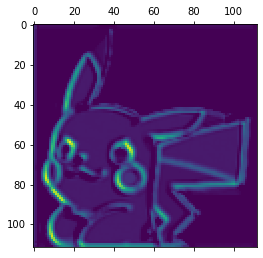

In [18]:
grid = GridspecLayout(4, 2, height='600px')

# left part of the layout
grid[0, 0] = create_textfield()
grid[1, 0] = create_interact_button()
grid[2, 0] = create_image_original()

# right part of the layout
grid[0, 1] = create_conv_dropdown()
grid[1, 1] = create_conv_button()
#grid[2, 1] = create_filter()
#grid[3, 1] = create_filter_button()

display(grid)

## 3. Explanations
In this exercise we will use the LIME framework to generate explanations for the preditions of our model.
To this end you will extend your evaluation of exercise 1 by adding the LIME ImageExplainer.
For assistance, you can check out the example Images with keras from the official github repo [here](https://github.com/marcotcr/lime).

As presented in the slides ```num_samples``` and ```num_features``` are the most important parts you can tweak in the lime algorithm.
Try to find a suitable tradeoff between the accuracy of the explanations and the overall runtime, for your specific model, by adjusting those parameters accordingly.
Good values to start with are ```num_features```= 5, ```num_samples```= 800.
Moreover, Lime provides the possibility to filter the superpixels regarding their contributions towards the explanation.
The ```get_image_and_mask``` method has a ```min_weight``` argument which corresponds to the minimum weight of the superpixels
 to include in the explanation. This value can be useful to create meaningful explanations. You can start with setting
 ```min_weight``` to 0.1 and adjust accordingly.

After generating explanations with LIME, repeat the analysis of the wrongly classified images similar to exercise 1.
Have your initial assumptions been correct?
Briefly write down your insights.

# 3. Code here

In [19]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(X_test[0].astype('double'), model_vgg.predict, top_labels=5, hide_color=0, num_samples=800)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Explaining image:  BULBASAUR_54.jpeg


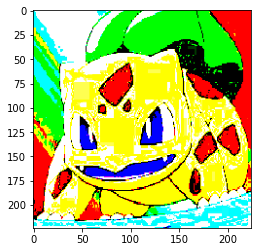

In [20]:
print('Explaining image: ', A_test[0])

# A_test is a list of image names equivalent to the list X_test consistinf of images presinted in numpy.ndarray
plt.imshow(X_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


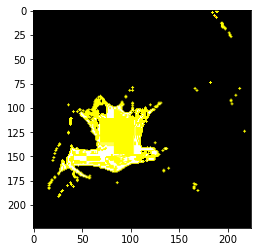

In [57]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


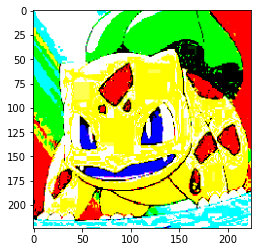

In [60]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


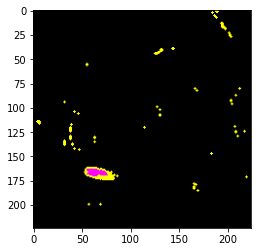

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=20, hide_rest=True, min_weight = 0)
plt.imshow(mark_boundaries(temp, mask))

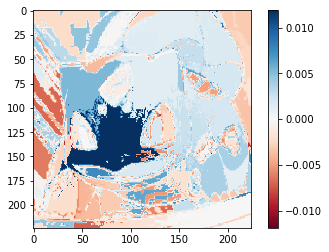

In [36]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Explaining image:  PIKACHU_14.jpeg


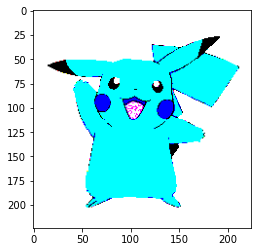

In [37]:
explanation_2 = explainer.explain_instance(X_test[14].astype('double'), model_vgg.predict, top_labels=5, hide_color=0, num_samples=800)

print('Explaining image: ', A_test[14])

# A_test is a list of image names equivalent to the list X_test consisting of images presinted in numpy.ndarray
plt.imshow(X_test[14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


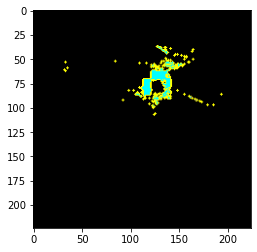

In [55]:
temp, mask = explanation_2.get_image_and_mask(explanation_2.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


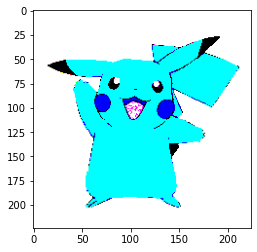

In [63]:
temp, mask = explanation_2.get_image_and_mask(explanation_2.top_labels[0], positive_only=False, num_features=100, hide_rest=False,  min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

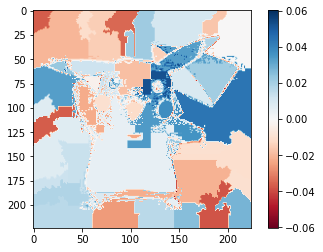

In [47]:
#Select the same class explained on the figures above.
ind =  explanation_2.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_2.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_2.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Explaining image:  EEVEE_21.jpg


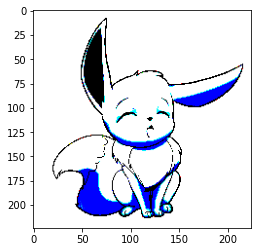

In [45]:
explanation_3 = explainer.explain_instance(X_test[12].astype('double'), model_vgg.predict, top_labels=5, hide_color=0, num_samples=800)

print('Explaining image: ', A_test[12])

# A_test is a list of image names equivalent to the list X_test consisting of images presinted in numpy.ndarray
plt.imshow(X_test[12])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


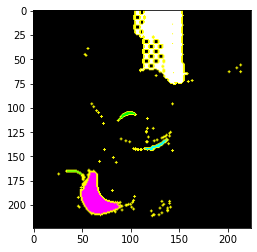

In [50]:
temp, mask = explanation_3.get_image_and_mask(explanation_3.top_labels[0], positive_only=False, num_features=20, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


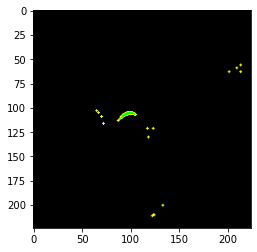

In [66]:
temp, mask = explanation_3.get_image_and_mask(explanation_3.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

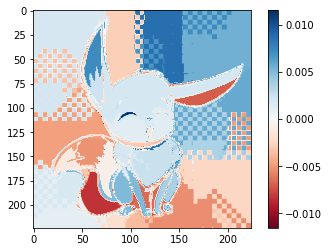

In [48]:
#Select the same class explained on the figures above.
ind =  explanation_3.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_3.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_3.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Have your initial assumptions been correct? Briefly write down your insights.

### Not at all. I thought that the most important parts of pokemons would be their thingies on the back (in case of bulbasaur) or tales (like in pikachu or eevee) but it turns out to be their eyes or heads.